# Transformer Network


**In this Notebook we will go through**:

* Create positional encodings to capture sequential relationships in data
* Calculate scaled dot-product self-attention with word embeddings
* Implement masked multi-head attention
* Build and train a Transformer model

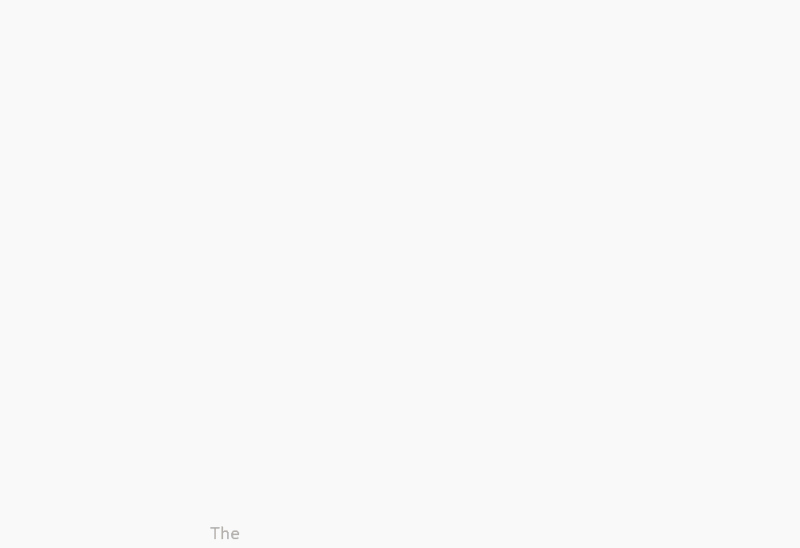

In [ ]:
from IPython.display import Image, display
display(Image(filename="1755412984098.gif"))

## Table of Contents

- [Packages](#0)
- [1 - Positional Encoding](#1)
    - [1.1 - Sine and Cosine Angles](#1-1)
    - [1.2 - Sine and Cosine Positional Encodings](#1-2)
- [2 - Masking](#2)
    - [2.1 - Padding Mask](#2-1)
    - [2.2 - Look-ahead Mask](#2-2)
- [3 - Self-Attention](#3)
- [4 - Encoder](#4)
    - [4.1 Encoder Layer](#4-1)
    - [4.2 - Full Encoder](#4-2)
- [5 - Decoder](#5)
    - [5.1 - Decoder Layer](#5-1)
    - [5.2 - Full Decoder](#5-2)
- [6 - Transformer](#6)


<a name='0'></a>
## Packages

Run the following cell to load the packages you'll need.

In [1]:
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization

<a name='1'></a>
## 1 - Positional Encoding

So here’s the deal: Transformers don’t know anything about the order of words by default.  
In RNNs, the sequence order is built-in since you feed tokens one by one. But in a Transformer, we pass the whole sequence at once, so we need to *manually* tell the model which word is in which position. That’s what **positional encoding** is for.

The trick is to generate vectors with sine and cosine functions that depend on the position in the sequence. The formulas look like this:

$$
PE_{(pos, 2i)} = \sin\!\left(\frac{pos}{10000^{\frac{2i}{d}}}\right) \\
PE_{(pos, 2i+1)} = \cos\!\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

Here:
- `d` = embedding dimension
- `pos` = the position of the token in the sequence
- `i` = index of the dimension inside the embedding vector

Basically, for every position, you build a sinusoidal pattern across the embedding dimensions. When you add these position vectors to your word embeddings, you’re giving the model a sense of order — without messing up the meaning of the embeddings (since sine/cosine values are between -1 and 1).

---
<a name='1-1'></a>
### 1.1 - Sine and Cosine Angles

Notice that the only difference between the sine and cosine equations is whether the dimension index is even or odd.  
We can think of the “angle” being:

$$
\theta(pos, i, d) = \frac{pos}{10000^{\frac{2i}{d}}}
$$

So for dimension 0 and 1, the angle is the same, but one gets passed through `sin`, the other through `cos`. Same for 2 and 3, and so on. That’s why you get pairs of sine/cosine waves with different frequencies across the dimensions.  
This way, every posi
 
 

In [2]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    
    # Get i from dimension span k
    i = k//2
    # Calculate the angles using pos, i and d
    angles = pos/np.power(10000,(2*i/np.float32(d)))
    
    return angles

<a name='1-2'></a>
### 1.2 - Sine and Cosine Positional Encodings

Now you can use the angles you computed to calculate the sine and cosine positional encodings.

$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$

<a name='ex-2'></a>


In [3]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # initialize a matrix angle_rads of all the angles 
    pos = np.arange(positions)[:, np.newaxis]   # shape = (positions, 1)
    k = np.arange(d)[np.newaxis, :]            # shape = (1, d)
    
    angle_rads = get_angles(pos,k,d)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:,0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:,1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


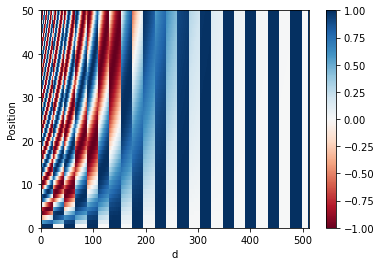

In [4]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Each row represents a positional encoding - notice how none of the rows are identical! You have created a unique positional encoding for each of the words.

<a name='2'></a>
## 2 - Masking

There are two types of masks that are useful when building your Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in your input sentence. 

<a name='2-1'></a>
### 2.1 - Padding Mask

Oftentimes your input sequence will exceed the maximum length of a sequence your network can process. Let's say the maximum length of your model is five, it is fed the following sequences:

    [["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"], 
     ["Jane", "visits", "Africa", "in", "September" ],
     ["Exciting", "!"]
    ]

which might get vectorized as:

    [[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600]
    ]
    
When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model:

    [[ 71, 121, 4, 56, 99],
     [ 2344, 345, 1284, 15, 0],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600, 0, 0, 0],
    ]
    

The [MultiheadAttention](https://keras.io/api/layers/attention_layers/multi_head_attention/) layer implemented in Keras, uses this masking logic.


In [5]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        decoder_token_ids -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, m) binary tensor
    """    
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits. 
    # this will allow for broadcasting later when comparing sequences
    return seq[:, tf.newaxis, :] 

In [6]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[1. 1. 0. 0. 1.]]

 [[1. 1. 1. 0. 0.]]

 [[0. 0. 0. 1. 1.]]], shape=(3, 1, 5), dtype=float32)


If we multiply (1 - mask) by -1e9 and add it to the sample input sequences, the zeros are essentially set to negative infinity. Notice the difference when taking the softmax of the original sequence and the masked sequence:

In [7]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + (1 - create_padding_mask(x)) * -1.0e9))

tf.Tensor(
[[7.2876644e-01 2.6809821e-01 6.6454901e-04 6.6454901e-04 1.8064314e-03]
 [8.4437378e-02 2.2952460e-01 6.2391251e-01 3.1062774e-02 3.1062774e-02]
 [4.8541026e-03 4.8541026e-03 4.8541026e-03 2.6502505e-01 7.2041273e-01]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[[7.2973627e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00 1.8088354e-03]
  [2.4472848e-01 6.6524094e-01 0.0000000e+00 0.0000000e+00 9.0030573e-02]
  [6.6483547e-03 6.6483547e-03 0.0000000e+00 0.0000000e+00 9.8670328e-01]]

 [[7.3057163e-01 2.6876229e-01 6.6619506e-04 0.0000000e+00 0.0000000e+00]
  [9.0030573e-02 2.4472848e-01 6.6524094e-01 0.0000000e+00 0.0000000e+00]
  [3.3333334e-01 3.3333334e-01 3.3333334e-01 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105860e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01 5.0000000e-01]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01 7.3105860e-01]]], shape=(3, 3, 5), dtype=float32)


<a name='2-2'></a>
### 2.2 - Look-ahead Mask

The look-ahead mask follows similar intuition. In training, you will have access to the complete correct output of your training example. The look-ahead mask helps your model pretend that it correctly predicted a part of the output and see if, *without looking ahead*, it can correctly predict the next output. 

For example, if the expected correct output is `[1, 2, 3]` and you wanted to see if given that the model correctly predicted the first value it could predict the second value, you would mask out the second and third values. So you would input the masked sequence `[1, -1e9, -1e9]` and see if it could generate `[1, 2, -1e9]`.


In [8]:
def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones
    
    Arguments:
        sequence_length -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

In [9]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(1, 3, 3), dtype=float32, numpy=
array([[[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]]], dtype=float32)>

<a name='3'></a>
## 3 - Self-Attention

As the authors of the Transformers paper state, "Attention is All You Need". 

<img src="self-attention.png" alt="Encoder" width="600"/>
<caption><center><font color='purple'><b>Figure 1: Self-Attention calculation visualization</font></center></caption>
    
The use of self-attention paired with traditional convolutional networks allows for parallelization which speeds up training. You will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to return rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries 
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply 
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode


In [10]:
# scaled_dot_product_attention 
from tensorflow.keras.layers import Softmax

def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """    
    matmul_qk = tf.matmul(q,k,transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1],tf.float32)  
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None: # Don't replace this None
        scaled_attention_logits += (1-mask)* -1e9

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights,v)  # (..., seq_len_q, depth_v)
    
    return output, attention_weights

<a name='4'></a>
## 4 - Encoder

The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder, which you'll build later in the assignment. In this section of the assignment, you will implement the Encoder by pairing multi-head attention and a feed forward neural network (Figure 2a). 
<img src="encoder_layer.png" alt="Encoder" width="400"/>
<caption><center><font color='purple'><b>Figure 2a: Transformer encoder layer</font></center></caption>

* `MultiHeadAttention` you can think of as computing the self-attention several times to detect different features. 
* Feed forward neural network contains two Dense layers which we'll implement as the function `FullyConnected`

Your input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.
   
* For the `MultiHeadAttention` layer, you will use the [Keras implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). If you're curious about how to split the query matrix Q, key matrix K, and value matrix V into different heads, you can look through the implementation. 
* You will also use the [Sequential API](https://keras.io/api/models/sequential/) with two dense layers to built the feed forward neural network layers.
    
**Note:** In Python, the `__call__` method allows you to call an object like a function. TensorFlow leverages this by providing a `call` function within Keras layers.  This means you can use a layer like `a_Layer(arg)` and TensorFlow will internally execute `a_Layer.call(arg)` to process your data.  This design makes it intuitive to apply layers within your TensorFlow models.    

In [11]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, embedding_dim)
    ])

<a name='4-1'></a>
### 4.1 Encoder Layer

Now you can pair multi-head attention and feed forward neural network together in an encoder layer! You will also use residual connections and layer normalization to help speed up training (Figure 2a).



In [13]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This architecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim=128, num_heads=8, fully_connected_dim=512,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            encoder_layer_out -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        # calculate self-attention using mha.
        # Dropout is added by Keras automatically if the dropout parameter is non-zero during training
        self_mha_output = self.mha(query=x,key=x,value=x,
                                      attention_mask = mask , training = training)  # Self attention (batch_size, input_seq_len, embedding_dim)
        
        # skip connection
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer 
        skip_x_attention = self.layernorm1(x+ self_mha_output)  # (batch_size, input_seq_len, embedding_dim)

        # pass the output of the multi-head attention layer through a ffn
        ffn_output = self.ffn(skip_x_attention)  # (batch_size, input_seq_len, embedding_dim)
        
        # apply dropout layer to ffn output during training 
        # use `training=training` 
        ffn_output = self.dropout_ffn(ffn_output,training=training)
        
        # apply layer normalization on sum of the output from multi-head attention (skip connection) and ffn output to get the
        # output of the encoder layer 
        encoder_layer_out = self.layernorm2(ffn_output+skip_x_attention)  # (batch_size, input_seq_len, embedding_dim)
        
        return encoder_layer_out
    

<a name='4-2'></a>
### 4.2 - Full Encoder

Now We're ready to build the full Transformer Encoder (Figure 2b), where we will embed your input and add the positional encodings we calculated. we will then feed the encoded embeddings to a stack of Encoder layers. 

<img src="encoder.png" alt="Encoder" width="330"/>
<caption><center><font color='purple'><b>Figure 2b: Transformer Encoder</font></center></caption>




In [15]:
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """  
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            x -- Tensor of shape (batch_size, input_seq_len, embedding_dim)
        """
        seq_len = tf.shape(x)[1]
        
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, embedding_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding[:, :seq_len, :]
        # Pass the encoded embedding through a dropout layer
        # use `training=training`
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x  # (batch_size, input_seq_len, embedding_dim)

<a name='5'></a>
## 5 - Decoder

The Decoder layer takes the K and V matrices generated by the Encoder and computes the second multi-head attention layer with the Q matrix from the output (Figure 3a).

<img src="decoder_layer.png" alt="Encoder" width="250"/>
<caption><center><font color='purple'><b>Figure 3a: Transformer Decoder layer</font></center></caption>



In [17]:
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim,
                                      dropout=dropout_rate)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
        
        # START CODE HERE
        # enc_output.shape == (batch_size, input_seq_len, embedding_dim)
        
        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1.
        # Dropout will be applied during training
        mult_attn_out1, attn_weights_block1 = self.mha1(x, x, x, attention_mask=look_ahead_mask, return_attention_scores=True , training= training)  # (batch_size, target_seq_len, embedding_dim)
        
        # apply layer normalization (layernorm1) to the sum of the attention output and the input 
        Q1 = self.layernorm1(mult_attn_out1+x)

        # BLOCK 2
        # calculate self-attention using the Q from the first block and K and V from the encoder output. 
        # Dropout will be applied during training
        # Return attention scores as attn_weights_block2
        mult_attn_out2, attn_weights_block2 = self.mha2(Q1, enc_output, enc_output, attention_mask=padding_mask, return_attention_scores=True , training=training)  # (batch_size, target_seq_len, embedding_dim)
        
        # apply layer normalization (layernorm2) to the sum of the attention output and the output of the first block
        mult_attn_out2 = self.layernorm2(mult_attn_out2 + Q1)  # (batch_size, target_seq_len, embedding_dim)
                
        #BLOCK 3
        # pass the output of the second block through a ffn
        ffn_output = self.ffn(mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)
        
        # apply a dropout layer to the ffn output
        # use `training=training`
        ffn_output = self.dropout_ffn(ffn_output)
        
        # apply layer normalization (layernorm3) to the sum of the ffn output and the output of the second block
        out3 = self.layernorm3(ffn_output+mult_attn_out2)  # (batch_size, target_seq_len, embedding_dim)

        return out3, attn_weights_block1, attn_weights_block2
    

<a name='5-2'></a> 
### 5.2 - Full Decoder
You're almost there! Time to use your Decoder layer to build a full Transformer Decoder (Figure 3b). You will embed your output and add positional encodings. You will then feed your encoded embeddings to a stack of Decoder layers. 


<img src="decoder.png" alt="Encoder" width="300"/>
<caption><center><font color='purple'><b>Figure 3b: Transformer Decoder</font></center></caption>


In [19]:
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, embedding_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, embedding_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # create word embeddings 
        x = self.embedding(x)  # (batch_size, target_seq_len, embedding_dim)
        
        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim,tf.float32))
        
        # calculate positional encodings and add to word embedding
        x += self.pos_encoding[:, :seq_len, :]

        # apply a dropout layer to x
        # use `training=training`
        x = self.dropout(x,training=training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights 
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 
            x, block1, block2 = self.dec_layers[i](x, enc_output ,training, look_ahead_mask=look_ahead_mask, 
                                                   padding_mask=padding_mask)
                                                 

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        
        # x.shape == (batch_size, target_seq_len, embedding_dim)
        return x, attention_weights

<a name='6'></a> 
## 6 - Transformer

Phew! This has been quite the assignment, and now you've made it to your last exercise of the Deep Learning Specialization. Congratulations! You've done all the hard work, now it's time to put it all together.  

<img src="transformer.png" alt="Transformer" width="550"/>
<caption><center><font color='purple'><b>Figure 4: Transformer</font></center></caption>
    
The flow of data through the Transformer Architecture is as follows:
* First your input passes through an Encoder, which is just repeated Encoder layers that you implemented:
    - embedding and positional encoding of your input
    - multi-head attention on your input
    - feed forward neural network to help detect features
* Then the predicted output passes through a Decoder, consisting of the decoder layers that you implemented:
    - embedding and positional encoding of the output
    - multi-head attention on your generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - a feed forward neural network to help detect features
* Finally, after the Nth Decoder layer, one dense layer and a softmax are applied to generate prediction for the next output in your sequence.


In [20]:
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')
    
    def call(self, input_sentence, output_sentence, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            input_sentence -- Tensor of shape (batch_size, input_seq_len)
                              An array of the indexes of the words in the input sentence
            output_sentence -- Tensor of shape (batch_size, target_seq_len)
                              An array of the indexes of the words in the output sentence
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            dec_padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(input_sentence,training=training, mask=enc_padding_mask )  # (batch_size, inp_seq_len, embedding_dim)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, embedding_dim)
        dec_output, attention_weights = self.decoder(output_sentence, enc_output, training=training, 
                                                     look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax
        final_output = self.final_layer(dec_output) # (batch_size, tar_seq_len, target_vocab_size)
        # END CODE HERE

        return final_output, attention_weights